# The N3.125km LARM-smoothed Model

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


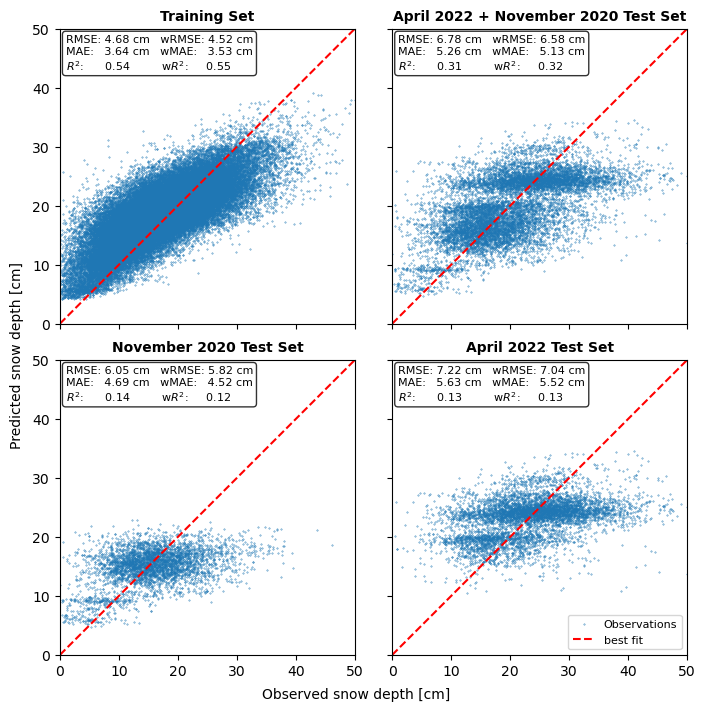

In [2]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

# imports
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.utils.standard_plots as sp

data ={
    'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km.pkl',
    'train': 'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_train.parquet',
    'nov': 'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2020-11-01_2020-12-01.parquet',
    'apr': 'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2022-04-01_2022-05-01.parquet'
    }

def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)



fig, ax = plt.subplots(2, 2, figsize=(7,7),sharex=True, sharey=True, layout='constrained')
model = pickle.load(open(data['model'], 'rb'))

train_df = pd.read_parquet(data['train'])
train_df = train_df[train_df['primary_id'].isin(['C2I'])]
nov_test_df = pd.read_parquet(data['nov'])
apr_test_df = pd.read_parquet(data['apr'])
test_df = pd.concat([nov_test_df, apr_test_df], ignore_index=True)


ax = ax.flatten()
for df in [train_df, test_df, nov_test_df, apr_test_df]:
    df.dropna(inplace=True)
    y_true = df['SD_mean'].values
    y_pred = model.predict(df)
    #weights = dataset['weight'].values

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
    wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))*100
    mae = np.mean(np.abs(y_true - y_pred))*100
    wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))*100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))


    if df.equals(train_df):
        title = 'Training Set'
        idx = 0
    elif df.equals(test_df):
        title = 'April 2022 + November 2020 Test Set'
        idx = 1
    elif df.equals(nov_test_df):
        title = 'November 2020 Test Set'
        idx = 2
    else:
        title = 'April 2022 Test Set'
        idx = 3

    obs_pred_plot(ax[idx], y_true*100, y_pred*100, val_range=(0,50), s=0.1)
    #ax[idx].set_title(f'{title}\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
    ax[idx].text(0.02, 0.98, 
        f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
        f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
        f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax[idx].set_title(f'{title}', fontsize=10, fontweight='bold')
    ax[idx].set_aspect('equal', 'box')
fig.supxlabel('Observed snow depth [cm]', fontsize=10)
fig.supylabel('Predicted snow depth [cm]', fontsize=10)
ax[-1].legend(loc=4,fontsize=8)
fig.savefig('data/fig/scatter_TrainAndTestset.png', dpi=300)

In [3]:
mins = [model.model.estimators_[i].tree_.value.min() for i in range(len(model.model.estimators_))]
maxs = [model.model.estimators_[i].tree_.value.max() for i in range(len(model.model.estimators_))]
print(f'Min prediction: {np.mean(mins)*100:.4f} cm')
print(f'Max prediction: {np.mean(maxs)*100:.4f} cm')

Min prediction: 2.6610 cm
Max prediction: 43.5973 cm


In [4]:
print(np.sqrt(0.003689534349821941)*100)  # weighted RMSE on training set

6.074153726916977


In [16]:
OIB_QL_df

,primary_id,secondary_id,time,doy,x,y,row,col,lon,lat,...,ssrd,strd,tclw,tciw,sf,e,istl1,istl2,istl3,istl4


In [24]:
input_df[input_df['secondary_id'].isin(['QuickLook'])]['SD_mean']

99480     0.081500
99481     0.081000
99482     0.081250
99483     0.050500
99484     0.071000
            ...   
142958    0.226219
142959    0.154515
142960    0.202441
142961    0.200074
142962    0.106267
Name: SD_mean, Length: 43483, dtype: float64

In [33]:
input_df.secondary_id.unique()

array(['2020-2021', '2021-2022', 'IDCSI4', 'QuickLook', 'ICEBIRD',
       'PAMARCMIP'], dtype=object)

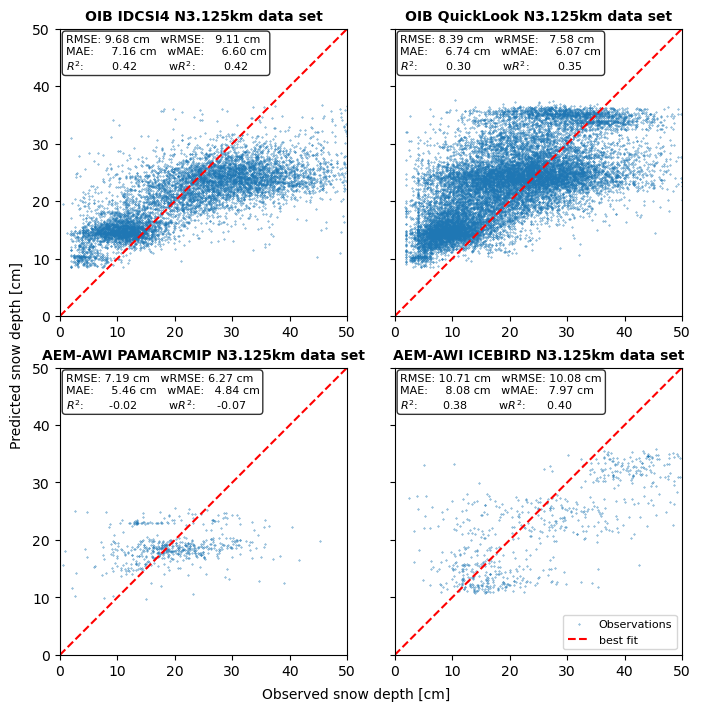

In [34]:
input_df = pd.read_parquet('C:\\Users\\ehate\\Desktop\\ASP\\ASP_code_projects\\ASP_predictor\\data\\intermediate\\datasets_final\\LARM_smoothed\\EASE2.0_N3.125km\\ASTD_v1.0-N3.125km-LARM_smoothed.parquet')
#input_df.dropna(inplace=True)
OIB_IDCSI4_df = input_df[input_df['secondary_id'].isin(['IDCSI4'])]
OIB_QL_df = input_df[input_df['secondary_id'].isin(['QuickLook'])] 
OIB_QL_df = OIB_QL_df[OIB_QL_df['time']<'2015-01-01']  # limit to before Apr 2022
AEM_PAMARCMIP_df = input_df[input_df['secondary_id'].isin(['PAMARCMIP'])]
AEM_ICEBIRD_df = input_df[input_df['secondary_id'].isin(['ICEBIRD'])]

fig, ax = plt.subplots(2, 2, figsize=(7,7), layout='constrained', sharey=True)
ax = ax.flatten()
for df in [OIB_IDCSI4_df, OIB_QL_df, AEM_PAMARCMIP_df, AEM_ICEBIRD_df]:
    #df.dropna(inplace=True)
    y_true = df['SD_mean'].values
    y_pred = model.predict(df)
    #weights = dataset['weight'].values

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
    wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))*100
    mae = np.mean(np.abs(y_true - y_pred))*100
    wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))*100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))


    if df.equals(OIB_IDCSI4_df):
        title = 'OIB IDCSI4 N3.125km data set'
        idx = 0
        ax[idx].text(0.02, 0.98, 
                f"RMSE: {rmse:.2f} cm   wRMSE:   {wrmse:.2f} cm" + "\n" +
                f"MAE:     {mae:.2f} cm   wMAE:     {wmae:.2f} cm" + "\n" +
                f"$R^2$:        {r2:.2f}         w$R^2$:        {wr2:.2f}", 
                        transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif df.equals(OIB_QL_df):
        title = 'OIB QuickLook N3.125km data set'
        idx = 1
        ax[idx].text(0.02, 0.98, 
                f"RMSE: {rmse:.2f} cm   wRMSE:   {wrmse:.2f} cm" + "\n" +
                f"MAE:     {mae:.2f} cm   wMAE:     {wmae:.2f} cm" + "\n" +
                f"$R^2$:        {r2:.2f}         w$R^2$:        {wr2:.2f}",
                        transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif df.equals(AEM_PAMARCMIP_df):
        title = 'AEM-AWI PAMARCMIP N3.125km data set'
        idx = 2
        ax[idx].text(0.02, 0.98, 
                f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
                f"MAE:     {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
                f"$R^2$:       {r2:.2f}         w$R^2$:      {wr2:.2f}", 
                        transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    elif df.equals(AEM_ICEBIRD_df):
        title = 'AEM-AWI ICEBIRD N3.125km data set'
        idx = 3
        ax[idx].text(0.02, 0.98, 
                f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
                f"MAE:     {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
                f"$R^2$:       {r2:.2f}         w$R^2$:      {wr2:.2f}",
                        transform=ax[idx].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    obs_pred_plot(ax[idx], y_true*100, y_pred*100, val_range=(0,50), s=0.1)
    ax[idx].set_aspect('equal', 'box')

    ax[idx].set_title(f'{title}', fontsize=10, fontweight='bold')
fig.supxlabel('Observed snow depth [cm]', fontsize=10)
fig.supylabel('Predicted snow depth [cm]', fontsize=10)
ax[-1].legend(loc=4,fontsize=8)
fig.savefig('data/fig/scatter_OIBandAEM.png', dpi=300)



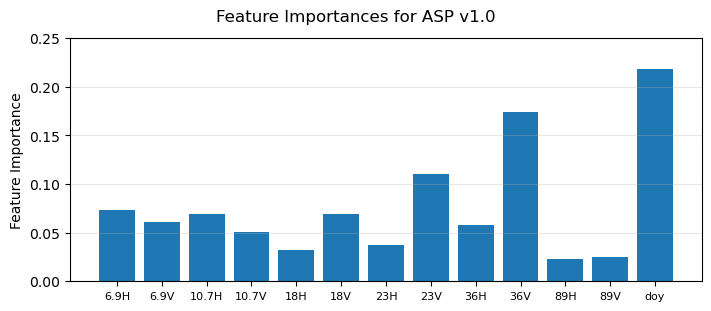

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7,3), layout='constrained')

x = np.arange(len(model.input_features))
ax.bar(x, model.model.feature_importances_, width=0.8)
ax.set_xticks(x, model.input_features, fontsize=8)
ax.set_ylim(0, 0.25)
fig.suptitle(f'Feature Importances for ASP v1.0')
ax.grid(alpha=0.3, axis='y')
ax.set_ylabel('Feature Importance')

fig.savefig('data/fig/feature_importances_ASPv1.0.pdf', dpi=300)
plt.show()

# Different model performances: Resolution and retracker

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


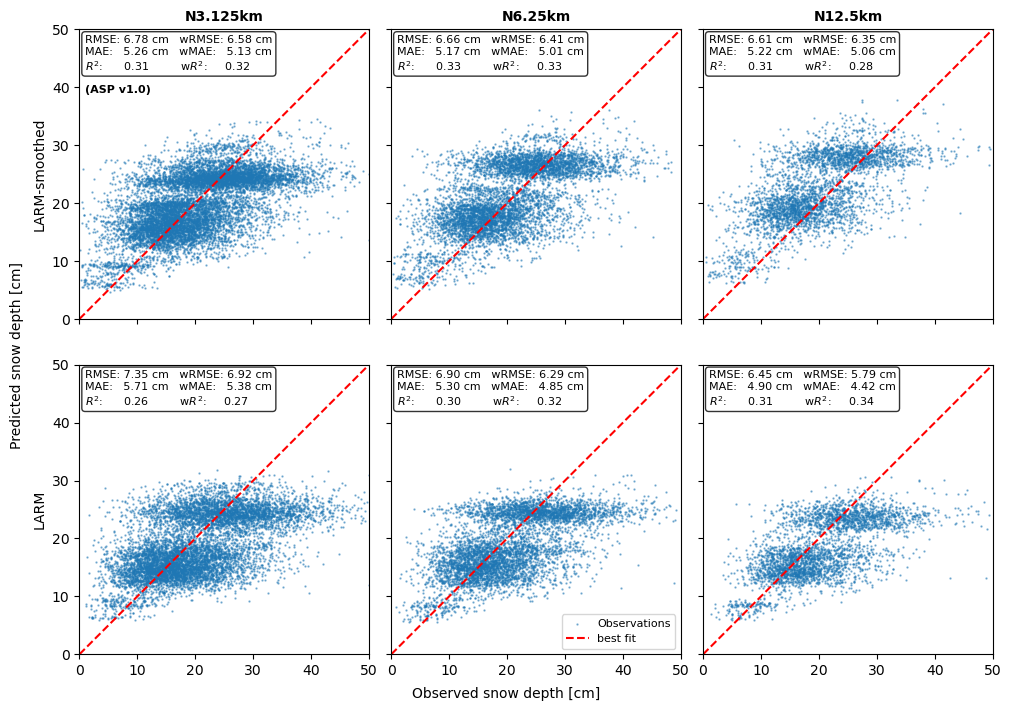

In [5]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

# imports
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.utils.standard_plots as sp

datasets = {
    'LARM-smoothed': {
        'N3.125km': {
            'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km.pkl',
            'nov': 'data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N3.125km/ASTD_v1.0-test_nov2020.parquet',
            'apr': 'data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N3.125km/ASTD_v1.0-test_apr2022.parquet'
        },
        'N6.25km': {
            'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N6.25km.pkl',
            'nov': 'data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N6.25km/ASTD_v1.0-test_nov2020.parquet',
            'apr': 'data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N6.25km/ASTD_v1.0-test_apr2022.parquet'
        },
        'N12.5km': {
            'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N12.5km.pkl',
            'nov': 'data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N12.5km/ASTD_v1.0-test_nov2020.parquet',
            'apr': 'data/intermediate/datasets_final/LARM_smoothed/EASE2.0_N12.5km/ASTD_v1.0-test_apr2022.parquet'
        },
    },
    'LARM': {
        'N3.125km': {
            'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM_N3.125km.pkl',
            'nov': 'data/intermediate/datasets_final/LARM/EASE2.0_N3.125km/ASTD_v1.0-test_nov2020.parquet',
            'apr': 'data/intermediate/datasets_final/LARM/EASE2.0_N3.125km/ASTD_v1.0-test_apr2022.parquet'
        },
        'N6.25km': {
            'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM_N6.25km.pkl',
            'nov': 'data/intermediate/datasets_final/LARM/EASE2.0_N6.25km/ASTD_v1.0-test_nov2020.parquet',
            'apr': 'data/intermediate/datasets_final/LARM/EASE2.0_N6.25km/ASTD_v1.0-test_apr2022.parquet'
        },
        'N12.5km': {
            'model': 'data/processed/models/v1.2/ASP_RFR-model_LARM_N12.5km.pkl',
            'nov': 'data/intermediate/datasets_final/LARM/EASE2.0_N12.5km/ASTD_v1.0-test_nov2020.parquet',
            'apr': 'data/intermediate/datasets_final/LARM/EASE2.0_N12.5km/ASTD_v1.0-test_apr2022.parquet'
        },
    }
}

def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)


i = 0
fig, ax = plt.subplots(2, 3, figsize=(10,7),sharex=True, sharey=True, layout='constrained')
for retracker, experiments in datasets.items():
    for experiment, files in experiments.items():
        model = pickle.load(open(files['model'], 'rb'))

        nov_test_df = pd.read_parquet(files['nov'])
        apr_test_df = pd.read_parquet(files['apr'])

        df = pd.concat([nov_test_df, apr_test_df], ignore_index=True)
        df.dropna(inplace=True)
        X = df
        y_true = df['SD_mean'].values
        y_pred = model.predict(X)

        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
        wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))*100
        mae = np.mean(np.abs(y_true - y_pred))*100
        wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))*100
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))

        cax = ax.flatten()[i]
        obs_pred_plot(cax, y_true*100, y_pred*100, val_range=(0,50), s=0.5,alpha=0.5)
        cax.set_aspect('equal', 'box')

        cax.text(0.02, 0.98, 
                f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
                f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
                f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                     transform=cax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        if i == 0:
            cax.text(0.02, 0.78, '(ASP v1.0)', fontsize=8, fontweight='bold', 
                     transform=cax.transAxes)
        i += 1

fig.supxlabel('Observed snow depth [cm]', fontsize=10)
fig.supylabel('Predicted snow depth [cm]', fontsize=10)
ax[0,0].set_ylabel('LARM-smoothed', fontsize=10)
ax[1,0].set_ylabel('LARM', fontsize=10)
ax[0,0].set_title('N3.125km', fontsize=10,fontweight='bold')
ax[0,1].set_title('N6.25km', fontsize=10,fontweight='bold')
ax[0,2].set_title('N12.5km', fontsize=10,fontweight='bold')
#ax[0,   ].set_title('N3.125km - DOY not included', fontsize=10,fontweight='bold')
ax[1,1].legend(loc=4,fontsize=8)
fig.savefig('data/fig/scatter_retrackerAndResolution.png', dpi=300)
plt.show()

# Different model performances: Parameter inclusions

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


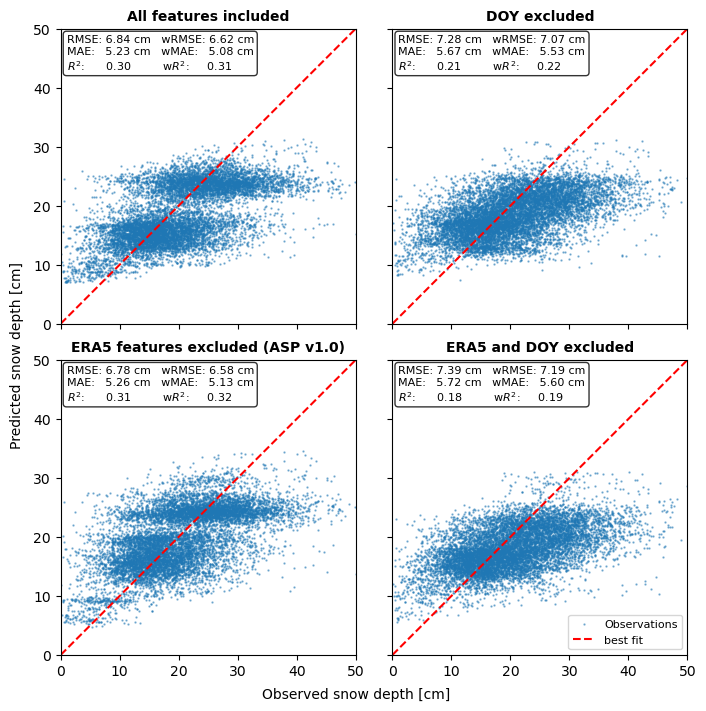

In [24]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

# imports
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.utils.standard_plots as sp

models = {
    'default':     'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km_wERA5.pkl',
    'noDOY':       'data/processed/models/v1.2//ASP_RFR-model_LARM-smoothed_N3.125km_wERA5noDOY.pkl',
    'noERA5':      'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km.pkl',
    'noERA5orDOY': 'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km_noDOY.pkl',
}

data_files = [
    'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2020-11-01_2020-12-01.parquet',
    'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2022-04-01_2022-05-01.parquet'    
]

def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)

titles = {
    'default': 'All features included',
    'noDOY': 'DOY excluded',
    'noERA5': 'ERA5 features excluded (ASP v1.0)',
    'noERA5orDOY': 'ERA5 and DOY excluded'}

df = pd.concat([pd.read_parquet(f) for f in data_files], ignore_index=True)
df.dropna(inplace=True)
fig, ax = plt.subplots(2, 2, figsize=(7,7),sharex=True, sharey=True, layout='constrained')
i = 0
for model_id, path in models.items():
    model = pickle.load(open(path, 'rb'))
    y_true = df['SD_mean'].values
    y_pred = model.predict(df)

    y_true = df['SD_mean'].values
    y_pred = model.predict(df)

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
    wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))*100
    mae = np.mean(np.abs(y_true - y_pred))*100
    wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))*100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))

    cax = ax.flatten()[i]
    obs_pred_plot(cax, y_true*100, y_pred*100, val_range=(0,50), s=0.5,alpha=0.5)
    cax.set_aspect('equal', 'box')

    cax.text(0.02, 0.98, 
            f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
            f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
            f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                    transform=cax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    cax.set_title(f'{titles[model_id]}', fontsize=10, fontweight='bold')
    i += 1    

fig.supxlabel('Observed snow depth [cm]', fontsize=10)
fig.supylabel('Predicted snow depth [cm]', fontsize=10)
ax[1,1].legend(loc=4,fontsize=8)
fig.savefig('data/fig/scatter_parameterInclusion.png', dpi=300)
plt.show()
    

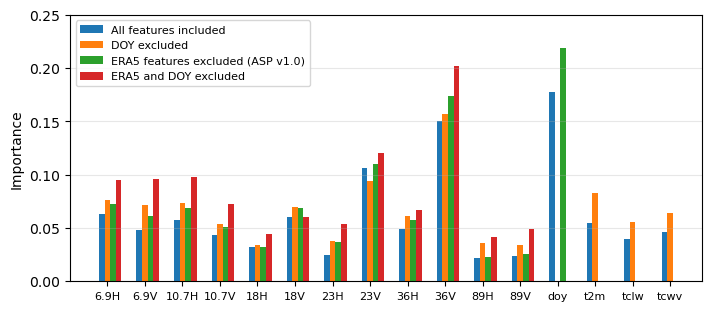

In [32]:
titles = {
    'default': 'All features included',
    'noDOY': 'DOY excluded',
    'noERA5': 'ERA5 features excluded (ASP v1.0)',
    'noERA5orDOY': 'ERA5 and DOY excluded'}

fig, ax = plt.subplots(1, 1, figsize=(7,3), layout='constrained')

i=0
for model_id, path in models.items():
    model = pickle.load(open(path, 'rb'))
    offset = 0.15*i - 0.15
    x = np.arange(16)
    fi = model.model.feature_importances_
    if model_id == 'noDOY':
        newfi = np.zeros(16)
        newfi[:12] = fi[:12]
        newfi[13:] = fi[-3:]
        #newfi[-1]=fi[-1]
        fi = newfi


    ax.bar(x[:len(fi)]+offset, fi, width=0.15)
    if i==0:
        ax.set_xticks(x, model.input_features, fontsize=8)
    #ax.set_title(f'Feature Importances: {titles[j]}', loc='left', fontsize=10, fontweight='bold')
    ax.set_ylim(0, 0.25)
    #ax[j].set_title(f'Feature Importances - {retracker} - {experiment}')
    ax.set_ylabel('Importance', fontsize=10)
    i += 1
    ax.legend(titles.values(), fontsize=8, loc=2)
    ax.grid(alpha=0.3, axis='y')
fig.savefig('data/fig/importance_parameterInclusion.pdf')
plt.show()

# Spatiotemporal parameters

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


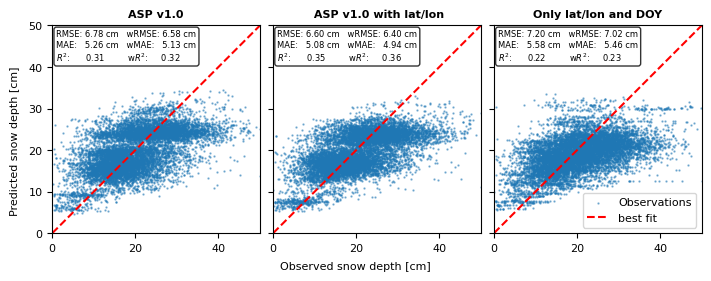

In [35]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor

# imports
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.utils.standard_plots as sp

models = {
    'default':     'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km.pkl',
    'wLatLon':     'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km_wLatLon.pkl',
    'LatLonDOY':   'data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km_onlyLatLonDOY.pkl',
}

data_files = [
    'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2020-11-01_2020-12-01.parquet',
    'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2022-04-01_2022-05-01.parquet'    
]

def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)

titles = {
    'default': 'ASP v1.0',
    'wLatLon': ' ASP v1.0 with lat/lon',
    'LatLonDOY': 'Only lat/lon and DOY'}


df = pd.concat([pd.read_parquet(f) for f in data_files], ignore_index=True)
df.dropna(inplace=True)
fig, ax = plt.subplots(1, 3, figsize=(7,2.7),sharex=True, sharey=True, layout='constrained')
i = 0
for model_id, path in models.items():
    model = pickle.load(open(path, 'rb'))
    y_true = df['SD_mean'].values
    y_pred = model.predict(df)

    y_true = df['SD_mean'].values
    y_pred = model.predict(df)

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
    wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples']))))*100
    mae = np.mean(np.abs(y_true - y_pred))*100
    wmae = np.mean(np.abs(y_true - y_pred) * (df['num_samples'] / np.mean(df['num_samples'])))*100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (df['num_samples'] / np.mean(df['num_samples'])) ))

    cax = ax.flatten()[i]
    obs_pred_plot(cax, y_true*100, y_pred*100, val_range=(0,50), s=0.5,alpha=0.5)
    cax.set_aspect('equal', 'box')

    cax.text(0.02, 0.98, 
            f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
            f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
            f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                    transform=cax.transAxes, fontsize=6, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    cax.set_title(f'{titles[model_id]}', fontsize=8, fontweight='bold')
    for label in cax.get_xticklabels():
        label.set_fontsize(8)
    for label in cax.get_yticklabels():
        label.set_fontsize(8)
    i += 1    

fig.supxlabel('Observed snow depth [cm]', fontsize=8)
fig.supylabel('Predicted snow depth [cm]', fontsize=8)
ax[2].legend(loc=4,fontsize=8)
fig.savefig('data/fig/scatter_spatiotemporalParams.png', dpi=300)
plt.show()

# Different model performances: Other model architechtures

C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor


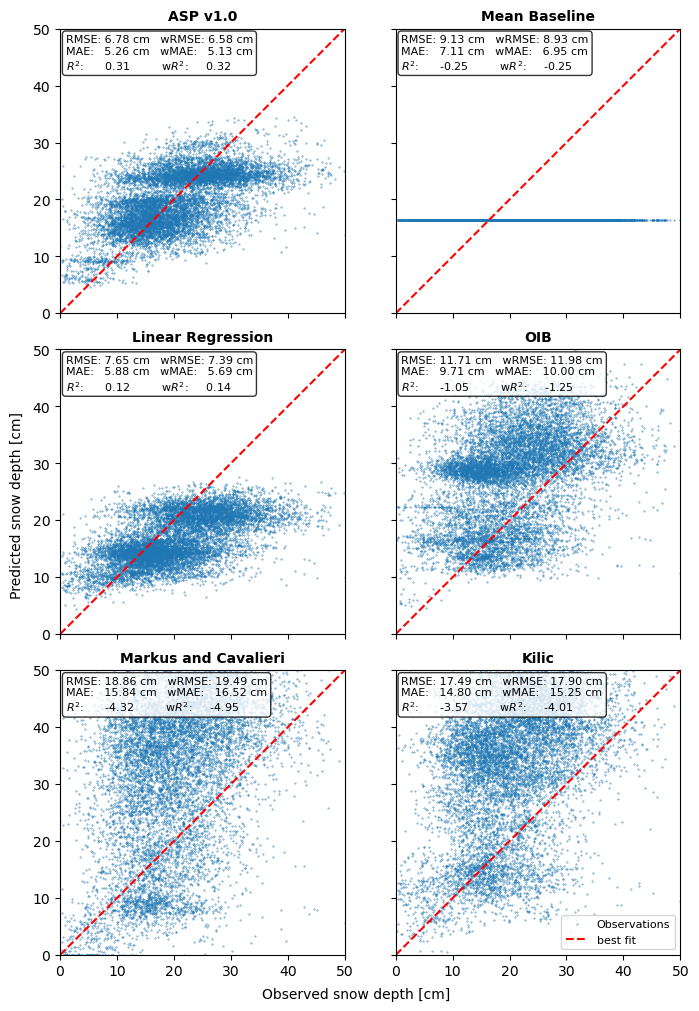

In [16]:
%cd C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.models import LinearRegression, KilicModel, MarkusAndCavalieriModel, MeanBaselineModel
import pickle

input_features = ['6.9H', '6.9V', '10.7H', '10.7V', '18H', '18V', '23H', '23V', '36H', '36V', '89H', '89V', 'doy']
target_feature = 'SD_median'
weight_feature = 'weights'


models = {
    'ASP v1.0': pickle.load(open('data/processed/models/v1.2/ASP_RFR-model_LARM-smoothed_N3.125km.pkl', 'rb')),
    'Mean Baseline': MeanBaselineModel(target_feature=target_feature, weight_feature=weight_feature),
    'Linear Regression': LinearRegression(input_features=input_features, target_feature=target_feature, weight_feature=weight_feature),
    'OIB': pickle.load(open( r'C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\processed\models\OIB\ASP_RFR-model_OIB_N3.125km.pkl', 'rb')),    
    'Markus and Cavalieri': MarkusAndCavalieriModel(target_feature=target_feature),     
    'Kilic': KilicModel(target_feature=target_feature),
}

test_files = [
    'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2020-11-01_2020-12-01.parquet',
    'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_test_2022-04-01_2022-05-01.parquet'    
    #'data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_train.parquet',
]

def obs_pred_plot(ax, y_true, y_pred, weights = None, val_range=(0,50),**kwargs):
    scatter = ax.scatter(y_true, y_pred, c=weights, label='Observations',**kwargs)
    ax.plot([val_range[0], val_range[1]], [val_range[0], val_range[1]], 'r--', label='best fit')
    ax.set_xlim(val_range)
    ax.set_ylim(val_range)

train_df = pd.read_parquet('data/intermediate/datasets/EASE2_LARM-smoothed_N3.125km_v1.1/ASP_train.parquet')
train_df.dropna(inplace=True)
train_df = train_df[train_df['primary_id'].isin(['C2I'])]
test_df = pd.concat([pd.read_parquet(f) for f in test_files], ignore_index=True)
test_df.dropna(inplace=True)
test_df = test_df[test_df['primary_id'].isin(['C2I'])]

fig, ax = plt.subplots(3, 2, figsize=(7,10),sharex=True, sharey=True, layout='constrained')
ax = ax.flatten()
for model_name, model in models.items():
    if model_name != 'ASP v1.0' and model_name != 'OIB':
        model.fit(train_df)
    y_true = test_df['SD_mean'].values
    y_pred = model.predict(test_df)
    # Calculate and print evaluation metrics

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))*100
    wrmse = np.sqrt(np.mean(((y_true - y_pred) ** 2) * (test_df['num_samples'] / np.mean(test_df['num_samples']))))*100
    mae = np.mean(np.abs(y_true - y_pred))*100
    wmae = np.mean(np.abs(y_true - y_pred) * (test_df['num_samples'] / np.mean(test_df['num_samples'])))*100
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    wr2 = 1 - (np.sum(((y_true - y_pred) ** 2) * (test_df['num_samples'] / np.mean(test_df['num_samples'])) ) / np.sum( ((y_true - np.mean(y_true)) ** 2) * (test_df['num_samples'] / np.mean(test_df['num_samples'])) ))

    obs_pred_plot(ax[list(models.keys()).index(model_name)], y_true*100, y_pred*100, val_range=(0,50), s=0.1)
    ax[list(models.keys()).index(model_name)].set_aspect('equal', 'box')
    ax[list(models.keys()).index(model_name)].text(0.02, 0.98, 
        f"RMSE: {rmse:.2f} cm   wRMSE: {wrmse:.2f} cm" + "\n" +
        f"MAE:   {mae:.2f} cm   wMAE:   {wmae:.2f} cm" + "\n" +
        f"$R^2$:      {r2:.2f}         w$R^2$:     {wr2:.2f}", 
                transform=ax[list(models.keys()).index(model_name)].transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax[list(models.keys()).index(model_name)].set_title(f'{model_name}', fontsize=10, fontweight='bold')
fig.supxlabel('Observed snow depth [cm]', fontsize=10)
fig.supylabel('Predicted snow depth [cm]', fontsize=10)
ax[-1].legend(loc=4,fontsize=8)

fig.savefig('data/fig/scatter_altModels.png', dpi=300)
plt.show()